# Image Classification With A Deep Neural Network
This notebook details the steps taken to implement and train a Deep Neural Network(DNN) on the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset in order to perform the computer vision task of image classification on the FashionMNIST test dataset partition. 

To build, train and test a neural network, the libraries TensorFlow and Keras are leveraged to provide the features and methods required to build the components of a neural network. Supporting libraries such as Pandas, Matplotlib and Numpy are utlised for visualisation and data processing

**[TensorFlow](https://www.tensorflow.org/)**: An open-source platform for implementing, training, and deploying machine learning models.

**[Keras](https://keras.io/)**: An open-source library used to implement neural network architectures that run on both CPUs and GPUs.

**[Matplotlib](https://matplotlib.org/)**: Tool utilized to create visualization plots in Python such as charts, graphs and more

**[Numpy](https://numpy.org/)**: Enables several mathematical computations and operations of array data structures.

In [24]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [25]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## FashionMNIST

The [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset consists of images of clothing (T-shirts, Trousers, Dresses and more) that originate from Zalando’s image directory. Zalando is a European e-commerce company founded in 2008.

The researchers in Zalando have created the Fashion-MNIST dataset that contains 70,000 images of clothing. More specifically, it contains 60,000 training examples and 10,000 testing examples, that are all grayscale images with the dimension 28 x 28 categorized into 10 classes.

[**Keras Dataset**](https://keras.io/api/datasets/) (keras.datasets)

In the practical world of machine learning, obtaining dataset is costly in terms of time, money and effort.
But a few introductory datasets have been collated together to help students and researchers build and analyse the performance of models on specifics datasets.
Some of these dataset reside within the Keras API and are easily accessible through the [load_data()](https://keras.io/api/datasets/fashion_mnist/#load_data-function) method of each respective dataset.

To load the FashionMNIST: `keras.datasets.fashion_mnist.load_data()`

**Classes**
| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

**Dataset Partitions**

For this particular classification task, 55,000 training images, 10,000 test images, and 5,000 validation images are utilized.
- Training Data: This is the group of our dataset used to train the neural network directly. Training data refers to the dataset partition exposed to the neural network during training.
- Validation Data: This group of the dataset is utilized during training to assess the performance of the network at various iterations.
- Test Data: This partition of the dataset evaluates the performance of our network after the completion of the training phase.

The validation partition of the dataset is obtained from taking a slice of the training data. More specifically, the first 5000 training images and labels are assigned to the validation data.
The new training data is reassigned to every training data element but the first 5000 images in the original training data.

In [26]:
# Load Dataset and split into partitions
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Create a validation set from training images
validation_images = train_images[:5000]
validation_labels = train_labels[:5000]

# Re-assign the training images and labels
train_images, train_labels = train_images[5000:], train_labels[5000:]

## Analysing the dataset

As mentioned earlier the FashionMNIST dataset contains 70,000 grayscale images with the dimensions 28 x 28.
Below are the several methods to leverage in order to confirm the nunbers of elements within the dataset partitions.

* Using Numpy's array [shape attribute](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html#numpy.ndarray.shape). This is possbile as the `train_images`, `train_labels`, `test_images` etc, are all numpy arrays
    
* Using Python's [length method](https://www.w3schools.com/python/ref_func_len.asp) 

In [27]:
# Analyze the stuctural properties of the training dataset
print("Shape of training images", train_images.shape)
print("Shape of training labels", train_labels.shape)
print("\n")

# Alternatively you can use the Python len() method
print("Number of training images", len(train_images))
print("Number of training labels", len(train_labels))
print("\n")

# Analyze the stuctural properties of the test dataset
print("Shape of test images", test_images.shape)
print("Shape of test labels", test_labels.shape)
print("\n")

# Alternatively you can use the Python len() method
print("Number of test images", len(test_images))
print("Number of test labels", len(test_labels))

Shape of training images (55000, 28, 28)
Shape of training labels (55000,)


Number of training images 55000
Number of training labels 55000


Shape of test images (10000, 28, 28)
Shape of test labels (10000,)


Number of test images 10000
Number of test labels 10000


The FashionMNIST dataset labels range from the numbers 0-9. The cell below shows the values of three randomly chosen labels from training dataset.

And by the built in Numpy array methods `max()` and min `min()` it is possible to confirm the maximum and minimum label expected from the training dataset.

In [28]:
# Example of training label content
print(train_labels[0], train_labels[43], train_labels[1923])
print("Minimum value of training labels", train_labels.min())
print("Maximum value of training labels", train_labels.max())

4 2 1
Minimum value of training labels 0
Maximum value of training labels 9


It is also possible to observe the content of an element of the training dataset, or any other elements of the dataset by using the Python's list subscript.

`print(train_images[0])` prints to the console a numpy multidimensional array containing values between the numbers 0-255.

In [29]:
# Content of training images before normalisation
print(train_images[0])
print("Minimum value of pixel training images", train_images.min())
print("Maximum value of pixel training images", train_images.max())

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 196 21

## Normalisation

Before we proceed, we have to normalize the training image pixel values to values within the range 0 and 1. This is done by dividing each pixel value within the train and test images by 255 as this is the largest pixel value within the images (go back to previous cell for verfification).

Normalising the pixel values to numbers between 0 and 1 is not compulsury, but is a step advised to be taken when working with image dataset as large pixel values tend to prolong the training time, or time it takes for the network to converge. 

This is due to the fact that weights within the neural network take on really small values and conducting matrix multiplcation between the small values of the weights and large values of normal pixels will result in larger outputs, which increases the time taken for the network to train or converge.

Refer to [01_implementing_DNN](https://resources.oreilly.com/binderhub/practical-introduction-to-the-world-of-computer-vision-and-deep-learning/blob/master/notebooks/01_implementing_DNN.ipynb) notebook for example on viewing neural network weigths.


In [30]:
# Normalise training, test and validation images
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = validation_images / 255.0

Observing the contents of an element of the training data will display pixels values ranging from 0 to 1, the cell below demonstrates this.

In [31]:
# Content of training images after normalisation
print(train_images[0])
print("Minimum value of training images", train_images.min())
print("Maximum value of training images", train_images.max())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00392157 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.17254902
  0.49803922 0.71372549 0.7254902  0.63137255 0.47058824 0.21568627
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.16470588 0.77647059 0.98431373
  1.         0.98431373 0.97647059 0.96862745 1.         0.98823529
  0.83921569 0.39215686 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00784314 0.         0.         0.91372549 0

## Visualising FashionMNIST

The values of the dataset label correspond to item of clothings. In order to train neural networks it's practical to represent classes using integers, as opposed to their corresponding character representation, this is called Integer Encoding, as we are assigning each unique class to a integer representation.

In the following cells below the first 20 training image labels are obtained and the correpsonding textual representation of the integer is printed aswell. 

In [32]:
fashion_mnist_class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

for i in range(20):
    print("Label value:", train_labels[i], "Label text:", fashion_mnist_class_names[train_labels[i]])

Label value: 4 Label text: Coat
Label value: 0 Label text: T-shirt/top
Label value: 7 Label text: Sneaker
Label value: 9 Label text: Ankle boot
Label value: 9 Label text: Ankle boot
Label value: 9 Label text: Ankle boot
Label value: 4 Label text: Coat
Label value: 4 Label text: Coat
Label value: 3 Label text: Dress
Label value: 4 Label text: Coat
Label value: 0 Label text: T-shirt/top
Label value: 1 Label text: Trouser
Label value: 8 Label text: Bag
Label value: 6 Label text: Shirt
Label value: 3 Label text: Dress
Label value: 6 Label text: Shirt
Label value: 4 Label text: Coat
Label value: 3 Label text: Dress
Label value: 2 Label text: Pullover
Label value: 8 Label text: Bag


Visualising the clothing item within the first 20 training images is a way to verify the first 20 training images integer encoding coreresponds to their textual representation.

Matplotlib's [pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) to generate figures that contain the images of the first 20 data points of the training data. The key method used for visualising image is pyplot [imshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib.pyplot.imshow) method.

In the cell below we iterate through the first 20 data points of the trianing data and display both the image and the textual reprsentation of the integer encoding of the associated class. And you can verify by observation that the class names corresponds to the content of the image.

Now we can build our neural network!

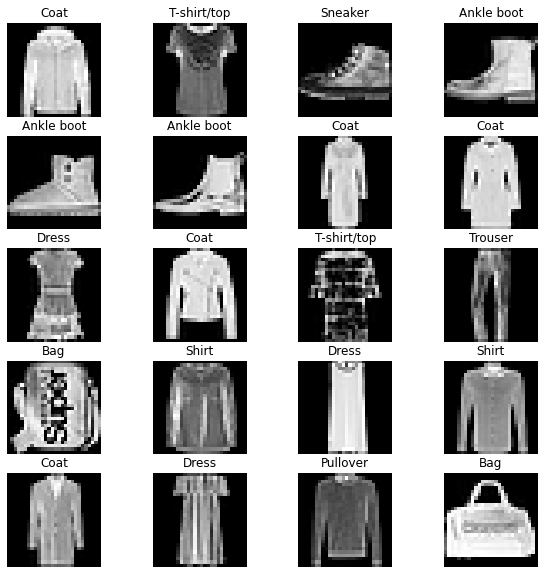

In [33]:
# Visualising data
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.axis("off")
    plt.title(fashion_mnist_class_names[train_labels[i]])
    plt.imshow(train_images[i], cmap='gray', vmin=0, vmax=1)
plt.show()

## Neural Network Implementation

The neural network implmented is a simple deep neural network with an input layers, three hidden layers and an output layer.

In feed forward neural networks the number of units reduces as we move down the layers towards the output layer, for several reasons, mainly due to the fact that you require more neurons to process inputs in the earlier layers and the last layer corresponds to the number of classes required for classificaiton, in the case of the fashionMNIST dataset this will be 10. 

Also, it's has been discovered by reasearchers that there's no additional benefit to performance or accuracy gained by increasing the number of neurons within layers, therefore leveraging high number of neurons within layers will lead to high computational cost at no additional gain.

**Note: For detailed explanation on the components of a neural network, please refer to [01_implementing_DNN](https://resources.oreilly.com/binderhub/practical-introduction-to-the-world-of-computer-vision-and-deep-learning/blob/master/notebooks/01_implementing_DNN.ipynb)**

In [57]:
# Classification MLP(Multilayer perceptron) with three hidden layers
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(units=784, activation=keras.activations.relu),
    keras.layers.Dense(units=500, activation=keras.activations.relu),
    keras.layers.Dense(units=250, activation=keras.activations.relu),
    keras.layers.Dense(units=10, activation=keras.activations.softmax)
])

## Neural Network Structural Information

A structural summary of the neural network implemented above is obtainable by calling our model's 'summary' method. By calling the summary method, we gain information on the model properties such as layers, layer type, shapes, number of weights in the model, and layers.

[Keras documentation reference](https://keras.io/api/models/model/#summary-method)

In [58]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_17 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_18 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                7850      
Total params: 1,854,170
Trainable params: 1,854,170
Non-trainable params: 0
_________________________________________________________________


## Neural Network Hyperparameters and More
### Compilation
Keras provides the `Model.compile()` method which is available to the `model` object instantiated earlier in this notebook. The compile function enables the actual building of the model we have implemented behind the scene with some additional characteristics such as the `loss` function, `optimizer`, and metrics.

To train the network, we utilize a loss function that calculates the difference between the predicted values provided by the network and actual values of the training data.

The `learning rate` loss values and the optimizer algorithm facilitates the number of changes made to the weights within the network. 

Supporting factors such as `momentum` and `learning rate schedule`, provide the ideal environment to enable the network training to converge, herby getting the training loss values as close to zero as possible.

### Definitions
* **Learning Rate**: An integral component of a neural network as it’s a factor value that determines the level of updates that are made to the values of the weights of the network.

    In a visualization exercise, the function to be solved can be depicted as a hyperbolic curve in n-dimensional parameter space.
    The learning rate is a component that affects the step size that the current parameter values take towards a local/global minima; hence the learning rate directly affects the rate of convergence of a network during training. 

    If the learning rate is too small the network might take several iterations and epochs to converge. On the other hand, if the learning rate is too high, there is a risk of overshooting the minima, and as a result of this our training doesn’t converge. Selecting the appropriate learning rate can be a time staking exercise.
    
* **Learning rate schedule**: A constant learning rate can be utilized during the training of a neural network, but this can increase the amount of training that has to take place to arrive at optimal neural network performance. By utilizing the learning rate schedule, we introduce a timely reduction or increment of the learning rate during training to arrive at an optimal training outcome of the neural network.

* **Learning rate Decay**: Learning rate decay reduces the oscillations of steps taken towards a local minimum during gradient descent. By reducing the learning rate to a smaller value compares to the learning rate value utilized at the start of the training, we can steer the network towards a solution that oscillates in smaller ranges around a minimum.

* **Loss Function**: This is a method that quantifies ‘how well’ a machine learning model performs. The quantification is an output(cost) based on a set of inputs, which are referred to as parameter values. The parameter values are used to estimate a prediction, and the ‘loss’ is the difference between the prediction and the actual values.

* **Optimizer**: An optimizer within a neural network is an algorithmic implementation that facilitates the process of gradient descent within a neural network by minimizing the loss values provided via the loss function.


### More Explanations
In the following cell the optimizer used for model compilation if instansiated along with sets of values passed into the Keras's implementation of Stotastic Gradient Decent (SGD) [`keras.optimizers.SGD()`](https://keras.io/api/optimizers/sgd/)

Let's paint a picture. We have a loss function, and we need to find the optimum solution to solve the loss function. Here comes gradient descent, an algorithm that works by making changes to the values of the parameters/weight values that are within the model, all in the purpose of minimizing the cost function. An example of a loss function is Mean Squared Error.

Gradient descent intrinsic functionality works by finding the direction to take towards a local minimum based on the calculated gradient obtained from the error function with respect to the parameters at a particular data point.

Stotastic Gradient Decent (SGD) works by actually picking a single data point from the training set and computing the gradient, based on this single data point. Updates made within the parameter space during gradient descent can be noisy when using SGD. The noisiness characteristic of SGD is a result of its random nature that occurs when selecting data points from the training set to compute gradients from at each step.

The loss function leveraged for the neural network implemented in this notebook is [Sparse Categorical Crossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class). This loss function is preferred when conducting classification on multiple labels.

In [59]:
# Model compilation and initialisation of optimizer
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

## TensorBoard

TensorBoard provides visual insights into the events that occur during training at each epoch.
The training visualization provided by TensorBoard is stored in a ‘runs’ folder directory. We create a function to generate a folder directory and identify each log via a timestamp.

**Run Tensorboard using the command below from the location of the run folder on the terminal**
`tensorboard --logdir='runs'`


In [50]:
# Configure TensorBoard storage location
root_logdir = os.path.join(os.curdir, "runs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Training the Neural Network

The Model’s API [fit](https://keras.io/api/models/model_training_apis/#fit-method) method provides the tools to train the implemented network.

Passing specific arguments into the fit function enables the following:
* Specify the training data used for training `x` takes the training images and `y` accepts the numpy array  of training labels
* The `epochs` argument accepts an integer that corresponds to the numner of epochs the neural network is to be trained for
* Validation dataset to be used to validate the performance of the network during training to unseen data, specified by the `validation_data` argument
* We also utilize the `callbacks` argument, which in this instance, takes a list of the tensorboard callback created earlier and the early stopping callback created in the cell below.
* `batch_size`: Dicates the amound of data points presented to the network before a gradient update. If a batch size numner is not specified, the default batch size within Keras when training a neural network is 32. The network implemented in this notebook is trained for a total of 60 epochs. 
    


**In summary, we train the model for a maximum of 60 epochs, where we feed forward all our training data in batches of 32 (batch size) through the network at each epoch.**
**An update is made to our network’s weights parameters after it’s seen 32 training images and labels.**
**The ‘fit’ method takes additional arguments that are in the [official Keras documentation](https://keras.io/api/models/model_training_apis/#fit-method).**
**With the utilization of early stopping, a halt to training is made once no improvement in the validation loss is recorded after 3 epochs. Early stopping can save you hours, especially in the scenario where your network begins to overfit and stops converging.**

In [60]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
# Train model
model.fit(x=train_images, y=train_labels, epochs=60, validation_data=(validation_images, validation_labels), callbacks=[tensorboard_cb]) # early_stopping_cb

Epoch 1/60
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4851 - accuracy: 0.8269 - val_loss: 0.3730 - val_accuracy: 0.8648
Epoch 2/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3603 - accuracy: 0.8669 - val_loss: 0.3365 - val_accuracy: 0.8796
Epoch 3/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3252 - accuracy: 0.8782 - val_loss: 0.3221 - val_accuracy: 0.8794
Epoch 4/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2976 - accuracy: 0.8878 - val_loss: 0.3071 - val_accuracy: 0.8868
Epoch 5/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2781 - accuracy: 0.8951 - val_loss: 0.3035 - val_accuracy: 0.8848
Epoch 6/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2626 - accuracy: 0.9003 - val_loss: 0.2906 - val_accuracy: 0.8950
Epoch 7/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2489 - accuracy: 0.9061 - val_loss: 0.3030 - val_accuracy:

## Evalating the Model

To evaluate a model requires feed-forwarding through the network data that hasn’t been exposed to the network during training.
Evaluation of the model before actual utilization is a good indicator of observing how well the model can generalize to unseen data and perform in the 'wild'.
With the evaluation results, you can decide either to fine-tune the network hyperparameters or move forward to production after observing the accuracy of the evaluation over the test dataset.

Evaluation with the Keras library is easy as we simply call the [Model.evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) method and pass the test data to the model.

In the next cell we evaluate the trained model on the test data. Test data is presented to the model in batches of 32 (default `batch_size` number if not specified in the arguments)

In [61]:
model_evaluation_results = model.evaluate(x=test_images, y=test_labels, batch_size=32, verbose=2)
print("The test loss is", model_evaluation_results[0])
print("The test accuracy is", model_evaluation_results[1])

313/313 - 0s - loss: 0.6639 - accuracy: 0.8929
The test loss is 0.6639155745506287
The test accuracy is 0.8928999900817871


## Making Predictions with a trained model

To make predictions with the trained model, 10 images from our test data are used to emulate real-life scenario-based testing.
By using the `Model.predict()` method made available through our trained model, we can pass in the batch of test images to our model and extract the probability vector for each image.

For each image prediction we get several probability vectors containg  10 elements, and each element corresponds to the likelihood of the occurrence of a class from the 10 pieces of clothing classes in the FashionMNIST dataset.

In [40]:
# Prediction on test images using model.predict() method
practical_test_images =  test_images[:10]
prediction_probabilites = model.predict(practical_test_images)
prediction_probabilites

array([[7.5819889e-07, 9.1208576e-06, 3.2377073e-07, 6.2149246e-07,
        8.1511382e-07, 2.5368491e-04, 1.3118706e-06, 4.5344504e-03,
        1.1857862e-07, 9.9519879e-01],
       [1.1058904e-05, 5.1724163e-09, 9.4324785e-01, 2.1439674e-09,
        5.6624722e-02, 5.7087408e-11, 1.1641136e-04, 4.8691451e-10,
        5.1643725e-09, 4.0939022e-10],
       [3.1335223e-09, 1.0000000e+00, 2.6835953e-12, 1.2583422e-08,
        3.7742705e-11, 2.8568114e-14, 8.9642432e-10, 8.8696581e-15,
        1.0753931e-13, 6.5932977e-14],
       [3.9769268e-09, 9.9999988e-01, 1.0263189e-10, 1.1640610e-07,
        5.5131949e-10, 1.5622786e-12, 8.6979624e-09, 1.2879805e-13,
        1.8700631e-12, 3.0583964e-12],
       [4.8937861e-02, 6.6064313e-05, 4.6679466e-03, 1.2333761e-03,
        5.5661662e-03, 1.8852081e-05, 9.3940580e-01, 1.8083918e-05,
        2.0470765e-05, 6.5474662e-05],
       [1.9832632e-06, 9.9999714e-01, 7.5016118e-09, 5.8278818e-07,
        7.4019781e-09, 7.1688298e-12, 2.2736501e-07, 1.97

The probability vectors are not ideal and do not provide us the infromation required in a straightforward manner, which is the exact class an image is predicted to belong to.

There are two methods we leverage to solve this within this notebook

1. Custom Function `derive_predicted_classes` and Numpy's `argmax()` method
2. Using the `Model.predict_classes()` to get the exact singleclass the image corresponds to as opposed to a probabilty vector of all classes. 

Both methods provide the desired result, which is a list containing ten labels (integers) corresponding to the class each of the 10 test image correspond to.

In [41]:
# Altertive 1: Clean up model prediction using argmax to find the largest probablity
def derive_predicted_classes(prediction_probabilites):
    batch_prediction = []
    for vector in prediction_probabilites:
        batch_prediction.append(np.argmax(vector))
    return batch_prediction
    
model_prediction = derive_predicted_classes(prediction_probabilites)
model_prediction


[9, 2, 1, 1, 6, 1, 4, 6, 5, 7]

In [42]:
# Altertive 2: Get specific model preiction using the model.predict_classes() method
model_prediction = model.predict_classes(practical_test_images)
model_prediction

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=int64)

Here are the FashionMNIST classes that corresponds to the prediction the model made on the 10 test images

In [43]:
np.array(fashion_mnist_class_names)[model_prediction]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

## Visualising the predicitons

For verification that the prediciton made by the trained model is correct, it is possible to do one of the following:
1. Print the 10 test images correspomding test labels and compare with the predictions made
2. Visualise the 10 test images and use visual verfication to confirm that the predicted classs is what's present in the image content.

For this notebook method 2 is leveraged

In the cell below we iterate through the  10 data points of the test data and display both the image and the textual reprsentation of the predicted integer encoding of the test images. And you can verify by observation that the class names corresponds to the content of the image.

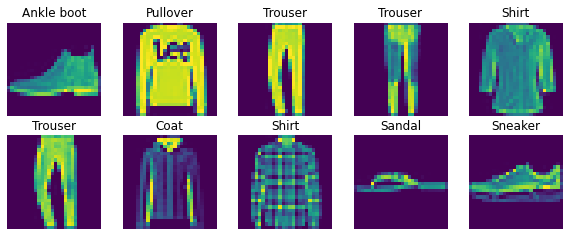

In [44]:
# Visualise the prediction result
plt.figure(figsize=(10,10))
for i in range(len(practical_test_images)):
    plt.subplot(5,5, i+1)
    plt.axis("off")
    plt.grid(False)
    plt.imshow(practical_test_images[i])
    plt.title(fashion_mnist_class_names[model_prediction[i]])
plt.show()

# Saving and Loading a model

The last step involves saving our model for future use.
Saving a trained TensorFlow model involves the calling of the [Model.save()](https://www.tensorflow.org/guide/keras/save_and_serialize) function and passing in the string representing name the model is saved as in the system's directory. The learned weights and internal configuration of the trained model is what's stored in the file.

In [45]:
model.save("image_classification_model.h5")

Using a saved model is achievable by calling the ‘load_model’ function made available via the Keras.models API.

In [46]:
# NOTE: If you encounter the error "AttributeError: 'str' object has no attribute 'decode'" when trying to load the model
# this is caused by using an higher version of h5py. Simply downgrade the package version of h5py.
# using pip "pip install 'h5py==2.10.0' --force-reinstall"
# or using conda "conda install -c anaconda h5py=2.10.0"
# reference: https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi

loaded_model = keras.models.load_model("image_classification_model.h5")
predictions = loaded_model.predict_classes(practical_test_images)
print(predictions)
print(np.array(fashion_mnist_class_names)[predictions])

[9 2 1 1 6 1 4 6 5 7]
['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt' 'Sandal' 'Sneaker']
